In [ ]:
# Import necessary libraries
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
uploaded = files.upload()
data = pd.read_csv('ML_Dataset.csv')

Saving ML_Dataset.csv to ML_Dataset.csv


In [ ]:
# Check the data structure
print(data.head())

          Timestamp User_ID   Application_Type Signal_Strength Latency  \
0  09-03-2023 10:00  User_1         Video_Call         -75 dBm   30 ms   
1  09-03-2023 10:00  User_2         Voice_Call         -80 dBm   20 ms   
2  09-03-2023 10:00  User_3          Streaming         -85 dBm   40 ms   
3  09-03-2023 10:00  User_4  Emergency_Service         -70 dBm   10 ms   
4  09-03-2023 10:00  User_5      Online_Gaming         -78 dBm   25 ms   

  Required_Bandwidth Allocated_Bandwidth Resource_Allocation Priority  \
0            10 Mbps             15 Mbps                 70%   Medium   
1           100 Kbps            120 Kbps                 80%      Low   
2             5 Mbps              6 Mbps                 75%     High   
3             1 Mbps            1.5 Mbps                 90%     High   
4             2 Mbps              3 Mbps                 85%     High   

    LocationX   LocationY  QoS_Level  PacketLoss  PacketDelay  Base_StationID  
0  374.540119  103.123869          3

In [ ]:
# Convert bandwidth and latency to standard units with extra checks
def convert_bandwidth(value):
    value = value.strip()  # Remove any leading or trailing whitespace
      if 'Kbps' in value:
        return float(value.replace(' Kbps', '').strip()) / 1000  # Convert Kbps to Mbps
    elif 'Mbps' in value:
        return float(value.replace(' Mbps', '').strip())
    elif 'Gbps' in value:
        return float(value.replace(' Gbps', '').strip()) * 1000  # Convert Gbps to Mbps
    else:
        raise ValueError(f"Unknown bandwidth unit in data: {value}")

In [ ]:
def convert_latency(value):
    value = value.strip()  # Remove any leading or trailing whitespace
    if 'ms' in value:
        return float(value.replace(' ms', '').strip())
    elif 's' in value:
        return float(value.replace(' s', '').strip()) * 1000  # Convert seconds to milliseconds
    else:
        raise ValueError(f"Unknown latency unit in data: {value}")

In [ ]:
# Apply conversions
data['Required_Bandwidth'] = data['Required_Bandwidth'].apply(convert_bandwidth)
data['Latency'] = data['Latency'].apply(convert_latency)

In [ ]:
print(data[['Required_Bandwidth', 'Latency']].head())


   Required_Bandwidth  Latency
0                10.0     30.0
1                 0.1     20.0
2                 5.0     40.0
3                 1.0     10.0
4                 2.0     25.0


In [ ]:
# Select relevant columns
data = data[['User_ID', 'Timestamp', 'Required_Bandwidth', 'Latency']]

In [ ]:
# Sort by UserID and Timestamp
data = data.sort_values(by=['User_ID', 'Timestamp']).reset_index(drop=True)

In [ ]:
# Check the data structure
print(data.head())

  User_ID         Timestamp  Required_Bandwidth  Latency
0  User_1  09-03-2023 10:00                10.0     30.0
1  User_1  09-03-2023 10:01                10.0     30.0
2  User_1  09-03-2023 10:02                10.0     30.0
3  User_1  09-03-2023 10:03                10.0     30.0
4  User_1  09-03-2023 10:04                10.0     30.0


In [ ]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
data[['Required_Bandwidth', 'Latency']] = scaler.fit_transform(data[['Required_Bandwidth', 'Latency']])

In [ ]:
# Define sequence length
sequence_length = 10

In [ ]:
# Function to create sequences
def create_user_sequences(data, user_id, seq_length):
    user_data = data[data['User_ID'] == user_id][['Required_Bandwidth', 'Latency']].values
    sequences, targets = [], []
    for i in range(len(user_data) - seq_length):
        sequences.append(user_data[i:i+seq_length])
        targets.append(user_data[i+seq_length])
    return np.array(sequences), np.array(targets)

In [ ]:
# Collect sequences for each user
all_sequences, all_targets = [], []
unique_users = data['User_ID'].unique()
for user_id in unique_users:
    user_sequences, user_targets = create_user_sequences(data, user_id, sequence_length)
    all_sequences.extend(user_sequences)
    all_targets.extend(user_targets)

In [ ]:
# Convert to numpy arrays and split into train and test sets
X = np.array(all_sequences)
y = np.array(all_targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Train multiple LSTM models (Ensemble)
def train_lstm_model(train_loader, input_size, hidden_size, num_layers, output_size, num_epochs=40, lr=0.001):
    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    return model



In [ ]:
# Initialize parameters
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = y_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train an ensemble of LSTM models
num_models = 3
models = [train_lstm_model(train_loader, input_size, hidden_size, num_layers, output_size) for _ in range(num_models)]

# Generate ensemble predictions
def ensemble_predictions(models, X_loader):
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for X_batch, _ in X_loader:
                X_batch = X_batch.to(device)
                output = model(X_batch)
                preds.append(output.cpu().numpy())
        all_preds.append(np.concatenate(preds, axis=0))
    return np.mean(all_preds, axis=0)

ensemble_test_preds = ensemble_predictions(models, test_loader)

# Train a Gradient Boosting Regressor on ensemble LSTM predictions
gbr_bandwidth = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_latency = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_bandwidth.fit(ensemble_test_preds[:, 0].reshape(-1, 1), y_test[:, 0].numpy())
gbr_latency.fit(ensemble_test_preds[:, 1].reshape(-1, 1), y_test[:, 1].numpy())

# Final predictions
final_bandwidth_preds = gbr_bandwidth.predict(ensemble_test_preds[:, 0].reshape(-1, 1))
final_latency_preds = gbr_latency.predict(ensemble_test_preds[:, 1].reshape(-1, 1))

In [ ]:
# Calculate evaluation metrics
mae_bandwidth = mean_absolute_error(y_test[:, 0].numpy(), final_bandwidth_preds)
mae_latency = mean_absolute_error(y_test[:, 1].numpy(), final_latency_preds)
r2_bandwidth = r2_score(y_test[:, 0].numpy(), final_bandwidth_preds)
r2_latency = r2_score(y_test[:, 1].numpy(), final_latency_preds)

# Threshold-based accuracy
def calculate_accuracy(y_true, y_pred, threshold=0.1):
    within_threshold = np.abs(y_true - y_pred) / y_true <= threshold
    accuracy = np.mean(within_threshold) * 100
    return accuracy

accuracy_bandwidth = calculate_accuracy(y_test[:, 0].numpy(), final_bandwidth_preds, threshold=0.1)
accuracy_latency = calculate_accuracy(y_test[:, 1].numpy(), final_latency_preds, threshold=0.1)

# Print results
print(f'Improved Mean Absolute Error (MAE) - Required Bandwidth: {mae_bandwidth:.4f}')
print(f'Improved Mean Absolute Error (MAE) - Latency: {mae_latency:.4f}')
print(f'Improved R-squared - Required Bandwidth: {r2_bandwidth:.4f}')
print(f'Improved R-squared - Latency: {r2_latency:.4f}')
print(f'Improved Threshold-Based Accuracy (10%) - Required Bandwidth: {accuracy_bandwidth:.2f}%')
print(f'Improved Threshold-Based Accuracy (10%) - Latency: {accuracy_latency:.2f}%')

Improved Mean Absolute Error (MAE) - Required Bandwidth: 0.0004
Improved Mean Absolute Error (MAE) - Latency: 0.0002
Improved R-squared - Required Bandwidth: 1.0000
Improved R-squared - Latency: 1.0000
Improved Threshold-Based Accuracy (10%) - Required Bandwidth: 94.29%
Improved Threshold-Based Accuracy (10%) - Latency: 98.24%


<ipython-input-112-071f3d87f86b>:9: RuntimeWarning: divide by zero encountered in divide
  within_threshold = np.abs(y_true - y_pred) / y_true <= threshold


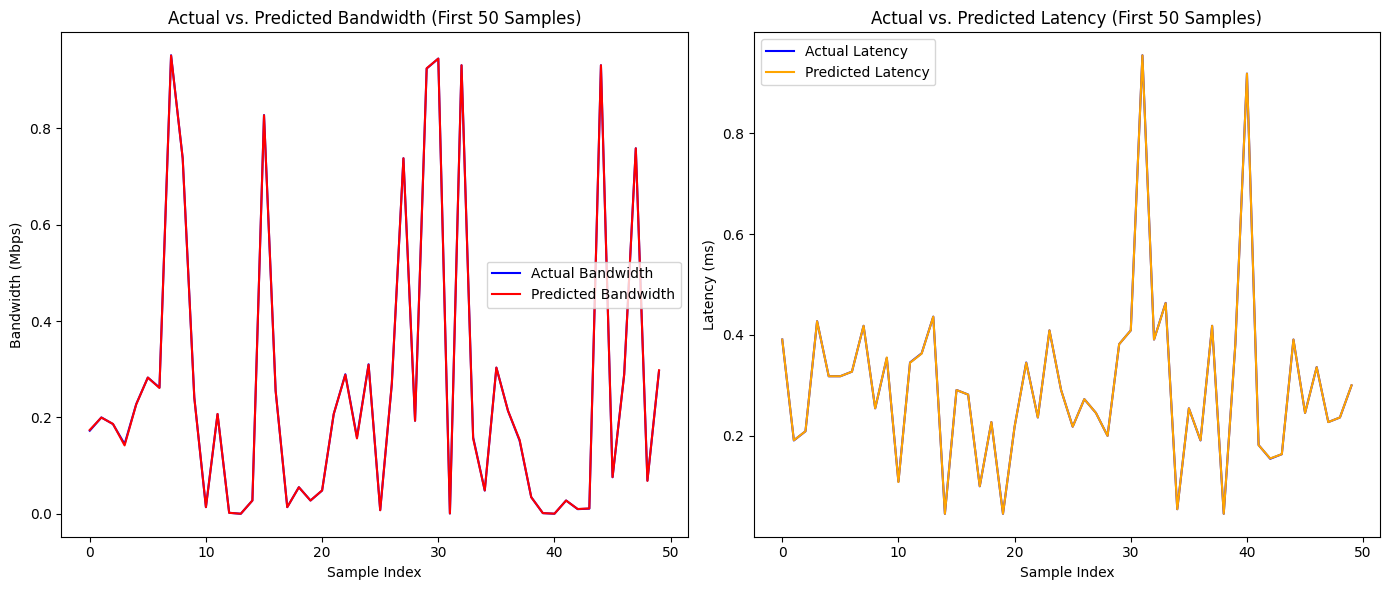

In [ ]:
import matplotlib.pyplot as plt

# Number of samples to plot
num_samples = 50

# Plot actual vs. predicted Bandwidth and Latency as straight lines
plt.figure(figsize=(14, 6))

# Bandwidth plot
plt.subplot(1, 2, 1)
plt.plot(y_test[:num_samples, 0].numpy(), label="Actual Bandwidth", color="blue")
plt.plot(final_bandwidth_preds[:num_samples], label="Predicted Bandwidth", color="red")
plt.title("Actual vs. Predicted Bandwidth (First 50 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Bandwidth (Mbps)")
plt.legend()

# Latency plot
plt.subplot(1, 2, 2)
plt.plot(y_test[:num_samples, 1].numpy(), label="Actual Latency", color="blue")
plt.plot(final_latency_preds[:num_samples], label="Predicted Latency", color="orange")
plt.title("Actual vs. Predicted Latency (First 50 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Latency (ms)")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Number of samples to plot
num_samples = 50

# Plot actual vs. predicted Bandwidth for the first few samples
plt.figure(figsize=(14, 6))

# Bandwidth plot
plt.subplot(1, 2, 1)
plt.plot(y_test[:num_samples, 0].numpy(), 'o', label="Actual Bandwidth", color="blue")
plt.plot(final_bandwidth_preds[:num_samples], 'x', label="Predicted Bandwidth", color="red")
plt.title("Actual vs. Predicted Bandwidth (First 50 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Bandwidth (Mbps)")
plt.legend()

# Latency plot
plt.subplot(1, 2, 2)
plt.plot(y_test[:num_samples, 1].numpy(), 'o', label="Actual Latency", color="blue")
plt.plot(final_latency_preds[:num_samples], 'x', label="Predicted Latency", color="red")
plt.title("Actual vs. Predicted Latency (First 50 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Latency (ms)")
plt.legend()

plt.tight_layout()
plt.show()
